In [11]:
from my_metrics import *
from sub_network import *
from data_loader import *
from plotting_utils import *

from sklearn.metrics import roc_curve

import matplotlib.pyplot as plt

In [12]:
image_dir1 = r"D:\snn_mask\snn_training_IEEE_mask\ours(560)\s1_ieee"
image_dir2 = r"D:\snn_mask\snn_training_IEEE_mask\ours(560)\s2_ieee"

images1 = load_images(image_dir1)
images2 = load_images(image_dir2)

pairs, labels = create_labels(images1, images2)

0 34
1 169
2 96
3 17
4 155
5 106
6 120
7 144
8 196
9 126
10 44
11 126
12 30
13 120
14 114
15 44
16 266
17 134
18 41
19 182
20 7
21 67
22 116
23 74
24 252
25 142
26 113
27 225
28 125
29 256
30 249
31 153
32 152
33 215
34 117
35 210
36 96
37 103
38 21
39 112
40 206
41 183
42 253
43 187
44 59
45 10
46 69
47 71
48 206
49 265
50 122
51 12
52 88
53 17
54 233
55 234
56 39
57 77
58 166
59 135
60 224
61 211
62 49
63 120
64 228
65 14
66 97
67 207
68 22
69 20
70 36
71 173
72 107
73 272
74 231
75 60
76 176
77 179
78 118
79 134
80 59
81 194
82 200
83 208
84 108
85 219
86 127
87 213
88 14
89 217
90 141
91 76
92 126
93 21
94 9
95 265
96 270
97 47
98 174
99 87
100 20
101 212
102 221
103 61
104 186
105 60
106 81
107 94
108 43
109 73
110 245
111 52
112 84
113 50
114 215
115 225
116 16
117 238
118 68
119 191
120 61
121 274
122 181
123 211
124 95
125 151
126 266
127 31
128 204
129 65
130 118
131 208
132 57
133 13
134 99
135 274
136 114
137 151
138 218
139 251
140 174
141 93
142 81
143 275
144 63
145 118
1

In [13]:
inputShape = (256, 256, 1)

inputA = Input(inputShape)
inputB = Input(inputShape)

featureExtractor = sub_network(inputShape)

featsA = featureExtractor(inputA)
featsB = featureExtractor(inputB)

distance = EuclideanDistance()([featsA, featsB])

outputs = Dense(1, activation="sigmoid")(distance)

model = Model(inputs=[inputA, inputB], outputs=outputs)

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 256, 256, 1)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 254, 254, 32)      320       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 127, 127, 32)     0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 127, 127, 32)      0         
                                                                 
 conv2d_5 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                       

test2_pairs.shape=(560, 2, 256, 256)
test2_labels.shape=(560,)
18/18 [==============================] - 1s 27ms/step


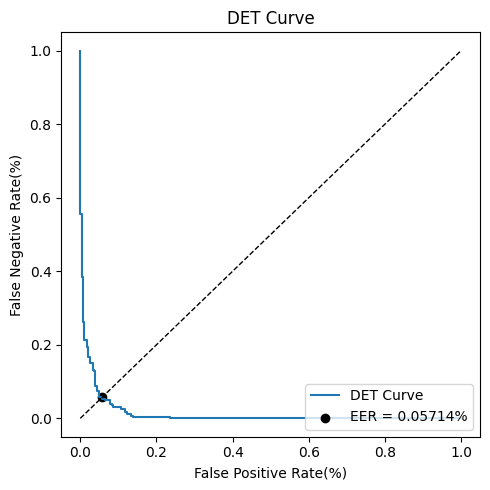

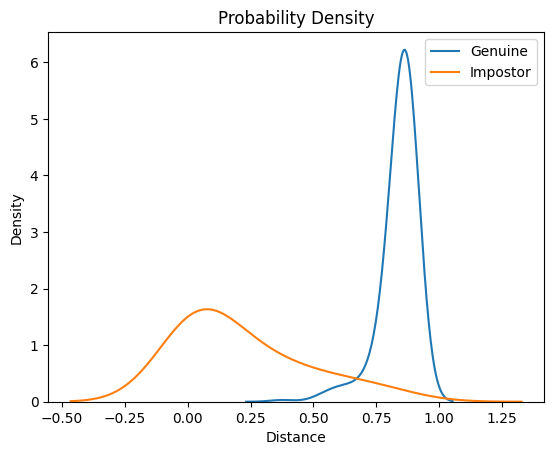

In [14]:
test2_pairs, test2_labels = pairs, labels

print("test2_pairs.shape={}".format(test2_pairs.shape))
print("test2_labels.shape={}".format(test2_labels.shape))

test2Pairs_0 = np.array([pair[0] for pair in test2_pairs]).reshape(-1, 256, 256, 1)
test2Pairs_1 = np.array([pair[1] for pair in test2_pairs]).reshape(-1, 256, 256, 1)

model.load_weights("snn.hdf5")
y_pred = model.predict([test2Pairs_0, test2Pairs_1]).ravel()
fpr, tpr, thresholds = roc_curve(test2_labels, y_pred)
eer, eer_threshold = compute_eer(fpr, tpr, thresholds)

EER = fpr[np.nanargmin(np.absolute((fpr - (1 - tpr))))]

with open("det_eer_data.txt", "w") as f:
    f.write(f"EER: {EER}\n")
    f.write(f"Threshold at EER: {eer_threshold}\n")

with open("det_curve_data.txt", "w") as f:
    f.write("False Positive Rate(%), False Negative Rate(%), Thresholds\n")
    for i in range(len(fpr)):
        f.write(f"{fpr[i]}, {1 - tpr[i]}, {thresholds[i]}\n") 

plot_det_curve(fpr, 1 - tpr, EER, label="DET Curve")

genuine_scores = y_pred[test2_labels == 1]
impostor_scores = y_pred[test2_labels == 0]

with open("scores_distribution.txt", "w") as f:
    f.write("Score Type,Score\n")
    for score in genuine_scores:
        f.write(f"Genuine,{score}\n")
    for score in impostor_scores:
        f.write(f"Impostor,{score}\n")

plot_density(genuine_scores, impostor_scores)

混淆矩陣:
 [[265  15]
 [ 16 264]]

True Negatives: 265
False Positives: 15
False Negatives: 16
True Positives: 264


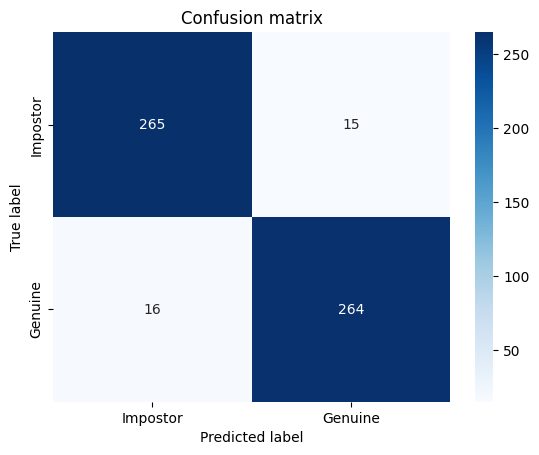

In [15]:
conf_matrix = calculate_confusion_matrix(test2_labels, y_pred, eer_threshold)
print("混淆矩陣:\n", conf_matrix)

tn, fp, fn, tp = conf_matrix.ravel()
print(f"\nTrue Negatives: {tn}")
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")
print(f"True Positives: {tp}")

class_names = ["Impostor", "Genuine"]
plot_confusion_matrix(conf_matrix, class_names)